## DTSA 5511 - Final Project: Movie Recommendation System

In [1]:
import os
import sys
import time
import re
import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.linalg import svd
from scipy.sparse.linalg import svds

from umap import UMAP

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import coo_matrix, csr_matrix

print('System version: {}'.format(sys.version))
print('Pandas version: {}'.format(pd.__version__))
print('Numpy version: {}'.format(np.__version__))

System version: 3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]
Pandas version: 1.5.3
Numpy version: 1.24.3


## Introduction
I selected the Recommender System as the topic for my final project because it presented the most significant challenge for me throughout the course. Week-3 programming assignment was particularly demanding. By delving further into this subject for my final project, I aim to gain a better understanding of its workings.

## 1. The Data: MovieLens Latest
I will be using the MovieLens Latest datasets, which are subject to change over time. It contains over 33 million ratings. To facilitate the modeling process, I will need to reduce the size of these datasets and undertake necessary cleaning procedures.

Data Source:

https://grouplens.org/datasets/movielens/latest/
* ml-latest.zip (size: 335 MB)

https://files.grouplens.org/datasets/movielens/ml-latest-README.html

This dataset (ml-latest) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 33832162 ratings and 2328315 tag applications across 86537 movies. These data were created by 330975 users between January 09, 1995 and July 20, 2023. This dataset was generated on July 20, 2023.

Users were selected at random for inclusion. All selected users had rated at least 1 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

## Identify Unsupervised Learning Problem
Unsupervised learning allows movie recommendation system to uncover patterns, relationships, or structures within the data without relying on labeled examples. This can lead to more flexible and data-driven recommendations as the system learns from the inherent structure of the movie dataset and user interactions.
I will implement several unsupervised learning models in this project.
1. Content-based recommendation system using Doc2Vec model. This is an unsupervised learning algorithm used for natural language processing tasks. The model will be trained on movie tags data.
2. Item-based collaborative filtering recommendation system. I will utilize sklearn NearestNeighbors, which is an unsupervised learner for implementing neighbor searches, to get the k nearest neighbors similarities and indices.
3. Model based recommendation system. I will use Scipy's Sparse Singular Value Decomposition and Surprise's SVD++ to make rating predictions, and subsequently, recommend movies with high predicted ratings to active users.

### Download MovieLens Latest dataset from url

In [2]:
import zipfile
import urllib.request

DOWNLOAD_DIR = 'dataset'

def unzip(name):
    path = os.path.join(DOWNLOAD_DIR, name)
    print(f"Unzipping the {name} zip file ...")        
    with zipfile.ZipFile(path, 'r') as data:
        data.extractall(DOWNLOAD_DIR)

def _progress(count, block_size, total_size):
    sys.stdout.write('\rDownload data %.1f%%' % (float(count * block_size)/float(total_size) * 100.0))
    sys.stdout.flush()

def download(url, name):
    path = os.path.join(DOWNLOAD_DIR, name)
    if not os.path.exists(path):        
        os.makedirs(DOWNLOAD_DIR, exist_ok=True)
        fpath, _ = urllib.request.urlretrieve(url, filename=path, reporthook=_progress)        
        statinfo = os.stat(fpath)
        print('\nSuccessfully downloaded', name, statinfo.st_size, 'bytes.')
        unzip(name)

class mlLatest:
    @staticmethod
    def load():        
        url = 'https://files.grouplens.org/datasets/movielens/ml-latest.zip'
        name = 'ml-latest'        
        download(url, f"{name}.zip")
        
        ratings_path = os.path.join(DOWNLOAD_DIR, name, 'ratings.csv')
        movies_path = os.path.join(DOWNLOAD_DIR, name, 'movies.csv')
        genome_tags_path = os.path.join(DOWNLOAD_DIR, name, 'genome-tags.csv')
        genome_scores_path = os.path.join(DOWNLOAD_DIR, name, 'genome-scores.csv')
        
        ratings = pd.read_csv(ratings_path)
        movies = pd.read_csv(movies_path)
        genome_tags = pd.read_csv(genome_tags_path)
        genome_scores = pd.read_csv(genome_scores_path)      
        return ratings, movies, genome_tags, genome_scores

In [3]:
ratings, movies, genome_tags, genome_scores = mlLatest.load()

Download data 100.0%
Successfully downloaded ml-latest.zip 350896731 bytes.
Unzipping the ml-latest.zip zip file ...


In [4]:
print('ratings shape:', ratings.shape)
ratings.head()

ratings shape: (33832162, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [5]:
print('movies shape:', movies.shape)
movies.head()

movies shape: (86537, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
n_ratings = len(ratings) - ratings.rating.isna().sum()
print('MovieLens Latest dataset contains {} ratings'.format(n_ratings))

MovieLens Latest dataset contains 33832162 ratings


## 2. Exploratory Data Analysis
### 2.1 Cleaning movie tags data
We will initially merge all the files containing tag information and its relevance score with the movies file that includes all the title information, creating a new file named "movies_tags." Subsequently, we will eliminate the year information from the titles. For instance, 'Toy Story (1995)' will be transformed into 'Toy Story.' This approach ensures that users do not require knowledge of the movie's release year when they input a movie title, to get recommendation of similar movies.

A particular movie can have many different tags with different relevance scores. We will create a column to rank movies based on the relevance of their tags, selecting only the most relevant tags, before combining all the tags for each movie.

Movie tags data will be used in our Content-based Recommendation System.

In [7]:
print('genome_tags shape:', genome_tags.shape)
genome_tags.head()

genome_tags shape: (1128, 2)


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [8]:
print('genome_scores shape:', genome_scores.shape)
genome_scores.head()

genome_scores shape: (18472128, 3)


,movieId,tagId,relevance
0,1,1,0.03200
1,1,2,0.02225
2,1,3,0.07000
3,1,4,0.05900
4,1,5,0.12300


In [9]:
def mv_tags_remove_year(title):
    # search title for (year) pattern
    s = re.search('\(\d{4}\)', title)
    
    # if pattern exists, remove from title
    if s:
        title = title[:s.span()[0]].strip()
    return title

In [10]:
# merge genome_scores, genome_tags and movies
movies_tags = genome_scores.merge(genome_tags, on='tagId').merge(movies[['movieId', 'title', 'genres']], on='movieId')

# remove movies year information from the titles
movies_tags['title'] = movies_tags['title'].map(mv_tags_remove_year)

# create a column that rank movies by their tags relevance
movies_tags['rank_relevance'] = movies_tags.groupby('movieId')['relevance'].rank(method='first', ascending=False).astype('int')

**Most Relevance Tags**

Get only tags that are most relevance for each movie. Those with rank below 100, with rank 1 being the most relevant, and combined all the tags for each movie.

In [11]:
movies_tags = movies_tags[movies_tags.rank_relevance <= 100].groupby(['movieId', 'title'])['tag'].apply(lambda x: ','.join(x)).reset_index()

In [12]:
pd.set_option('display.max_colwidth', None)
movies_tags.head(1)

,movieId,title,tag
0,1,Toy Story,"3d,action,adventure,affectionate,animal movie,animals,animated,animation,buddy movie,bullying,cartoon,catastrophe,cgi,chase,childhood,children,classic,clever,colourful,comedy,computer animation,cool,creativity,cult classic,cute,cute!,dialogue,disney,disney animated feature,emotional,entertaining,excellent,excellent script,exciting,family,fantasy,feel good movie,feel-good,friendship,fun,fun movie,funny,good,good action,good sequel,good soundtrack,great,great ending,great movie,greed,happy ending,heartwarming,highly quotable,honest,humorous,idealism,imagination,imdb top 250,interesting,kids,kids and family,life philosophy,light,masterpiece,mentor,movielens top pick,nostalgic,original,original plot,oscar,oscar (best animated feature),oscar (best directing),oscar (best effects - visual effects),oscar (best writing - screenplay written directly for the screen),oscar winner,pg,pixar,pixar animation,plot,quotable,redemption,runaway,saturn award (best special effects),sentimental,simple,story,storytelling,suprisingly clever,sweet,talky,technology,touching,toys,unlikely friendships,very funny,very good,visual,visually stunning,whimsical,witty"


In [13]:
pd.reset_option('display.max_colwidth')

In [14]:
def save_tags(mv_tags):
    save_dir = 'recsys'
    os.makedirs(save_dir, exist_ok=True)
    file_path = os.path.join(save_dir, 'movies_tags.csv')
    try:
        mv_tags.to_csv(file_path, index=False)
        print(f"The file has been successfully saved at: {file_path}")
    except ValueError as error:
        print(f"An error occured when saving data, due to : \n ValueError : {error}")

In [133]:
save_tags(movies_tags)

The file has been successfully saved at: recsys\movies_tags.csv


### 2.2 Cleaning ratings and movies data

In [144]:
titles = movies.title.values.tolist()

# Grab movie year information
years = [re.search(r'\((\d{4})\)', movie).group(1) if re.search(r'\((\d{4})\)', movie) else 'Year not found' for movie in titles]

# Create new column with Year information
movies['year'] = years

# Filter out movies with no Year information (around 600 movies)
movies = movies[movies.year != 'Year not found'] 

In [145]:
# One hot encoding genres
genres_encoded = movies['genres'].str.get_dummies(sep='|')

movies = pd.concat([movies, genres_encoded], axis=1)
movies.rename(columns={'(no genres listed)': 'unknown'}, inplace=True)
movies.head(3)

,movieId,title,genres,year,unknown,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [146]:
movies_newer = movies[['movieId']].copy()

# cast year column as integer, hence we can filter out some years
movies_newer['year'] = movies.year.astype(int)

# Grab only movies released later than year 2014
movies_newer = movies_newer[movies_newer.year > 2014]

# Grab these newer movies Id
mId = movies_newer.movieId.unique()

# Reduce our ratings data to contain only these newer movies
ratings = ratings[ratings.movieId.isin(mId)]

# Drop timestamp (this is the time information when a user rate a movie)
ratings = ratings.drop('timestamp', axis=1)

Next, we will grab only active users, defined as those that have rated at least 20 movies

In [147]:
user_rated = ratings.groupby('userId').count()
userId_todrop = user_rated[user_rated.rating < 20].index.tolist()

# get ratings data only for active users
ratings = ratings[~ratings.userId.isin(userId_todrop)]

# all movieId in our reduced ratings data
valid_movieId = ratings.movieId.unique()

# reduce our movies data to contain only movies that exist in our ratings data
movies = movies[movies.movieId.isin(valid_movieId)] 

In [148]:
# sort ratings first by userId then by movieId 
ratings = ratings.sort_values(by=['userId', 'movieId']).reset_index(drop=True)

# sort movies by movieId
movies = movies.sort_values(by=['movieId']).reset_index(drop=True)

In [149]:
# some sanity check
movies.movieId.nunique() == ratings.movieId.nunique()

True

In [150]:
print('Our data contains:\n \t* {} active users'.format(ratings.userId.nunique()))
print('\t* {} unique movies'.format(ratings.movieId.nunique()))
print('\t* {} ratings'.format(len(ratings)))

Our data contains:
 	* 21981 active users
	* 22487 unique movies
	* 1692161 ratings


In [138]:
# save our cleaned, reduced-size ratings and movies data to a directory: 'recsys'
def save_data(ratings, movies):
    save_dir = 'recsys'
    os.makedirs(save_dir, exist_ok=True)
    ratings_path = os.path.join(save_dir, 'ratings.csv')
    movies_path = os.path.join(save_dir, 'movies.csv')
    try:
        ratings.to_csv(ratings_path, index=False)
        movies.to_csv(movies_path, index=False)
        print(f"Both files have been successfully saved")
    except ValueError as error:
        print(f"An error occured when saving data, due to : \n ValueError : {error}")

In [139]:
save_data(ratings, movies)

Both files have been successfully saved


### Skip Cleaning
Skip cleaning MovieLens Latest Dataset. Use load_data() to get the ratings, movies and movies_tags data that we saved in the cleaning process.

In [15]:
def load_data():
    base_dir = 'recsys'
    ratings_path = os.path.join(base_dir, 'ratings.csv')
    movies_path = os.path.join(base_dir, 'movies.csv')
    mv_tags_path = os.path.join(base_dir, 'movies_tags.csv')
    ratings = pd.read_csv(ratings_path)
    movies = pd.read_csv(movies_path)
    movies_tags = pd.read_csv(mv_tags_path)
    
    return ratings, movies, movies_tags

In [16]:
# Use load_data() to get our cleaned, reduced-size ratings, movies
ratings, movies, movies_tags = load_data()

In [17]:
# save all userIds to a variable all_users
all_users = ratings.userId.unique()
print('There are {} users. \nTheir userIds are:\n{}'.format(len(all_users), all_users))

There are 21981 users. 
Their userIds are:
[    22     30     37 ... 330923 330931 330949]


### 2.3 Visualizing Data

In [18]:
ratings_viz = pd.DataFrame(ratings.groupby(['movieId'])['rating'].mean())
ratings_viz['count_rating'] = pd.DataFrame(ratings.groupby('movieId')['rating'].count())
ratings_viz.rename(columns={'rating': 'mean_rating'}, inplace=True)
print('On average, movies in the dataset have a rating of %.2f'% ratings_viz.mean(axis=0).values[0])
print('On average, each movie is rated {} times'.format(ratings_viz.mean(axis=0).values[1].astype(int)))
print('There are {} unique movies and {} unique users'.format(len(ratings_viz), ratings.userId.nunique()))
print('Maximum rating is {} and minimum rating is {}'.format(ratings.rating.max(), ratings.rating.min()))

On average, movies in the dataset have a rating of 2.95
On average, each movie is rated 75 times
There are 22487 unique movies and 21981 unique users
Maximum rating is 5.0 and minimum rating is 0.5


We need to have our rating data mean centered for the item-based Collaborative Filtering. We will do that later when we build our item-based CF.

Now, let's visualize mean rating for each movie against its rating count. 

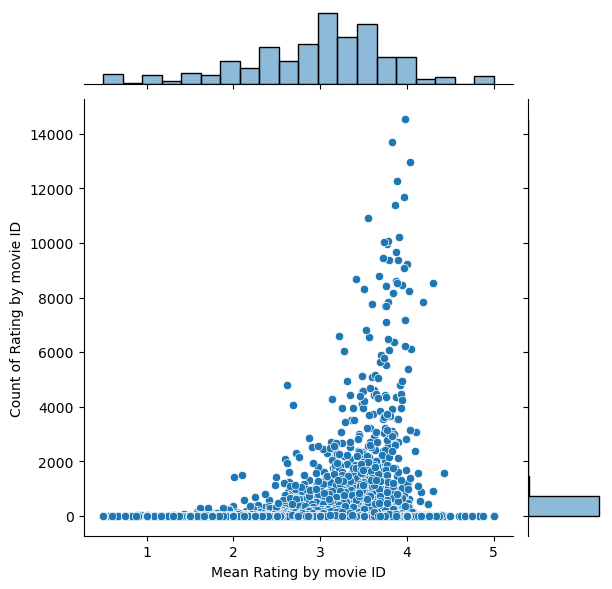

In [19]:
g = sns.jointplot(x='mean_rating', y='count_rating', data=ratings_viz, marginal_kws=dict(bins=20, alpha = 0.5))
g.ax_joint.set_xlabel('Mean Rating by movie ID')
g.ax_joint.set_ylabel('Count of Rating by movie ID');

As the mean rating increases, so does the number of people rating that movie, indicating an upward trend.

In [20]:
n_rated_less_than10 = len(ratings_viz[ratings_viz.count_rating < 5]['count_rating'])
n_rated_less_than10_pct = n_rated_less_than10  * 100 / len(ratings_viz)
print('{} % movies are rated by less than 5 users.'.format(round(n_rated_less_than10_pct, 1)))

53.8 % movies are rated by less than 5 users.


Next we will write a function to plot users profiles.

In [23]:
# merge ratings and movies to get all the information for plotting user profile
profile_df = ratings.merge(movies, on='movieId')
profile_df.head(1)

,userId,movieId,rating,title,genres,year,unknown,Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,22,111781,1.5,Mission: Impossible - Rogue Nation (2015),Action|Adventure|Thriller,2015,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0


In [24]:
def plot_2_users_profile(userIds, profile_df):
    plt.figure(figsize=(18, 6))
    for i, uid in enumerate(userIds):
        genres_count = profile_df[profile_df.userId == uid].iloc[:, 6:].sum(axis=0)
        user_mean = round(profile_df[profile_df.userId == uid].rating.mean(), 2)
        user_count = profile_df[profile_df.userId == uid].rating.count()
        plt.subplot(121+i)
        sns.barplot(x=genres_count.index, y=genres_count.values, palette='viridis')
        plt.xticks(rotation=45, fontsize=13) 
        plt.title("Movies by Genres already seen by userId: {}\nThis user has rated {} movies  -  User's mean rating: {}"\
                  .format(uid, user_count, user_mean), fontsize=16)
    plt.tight_layout()

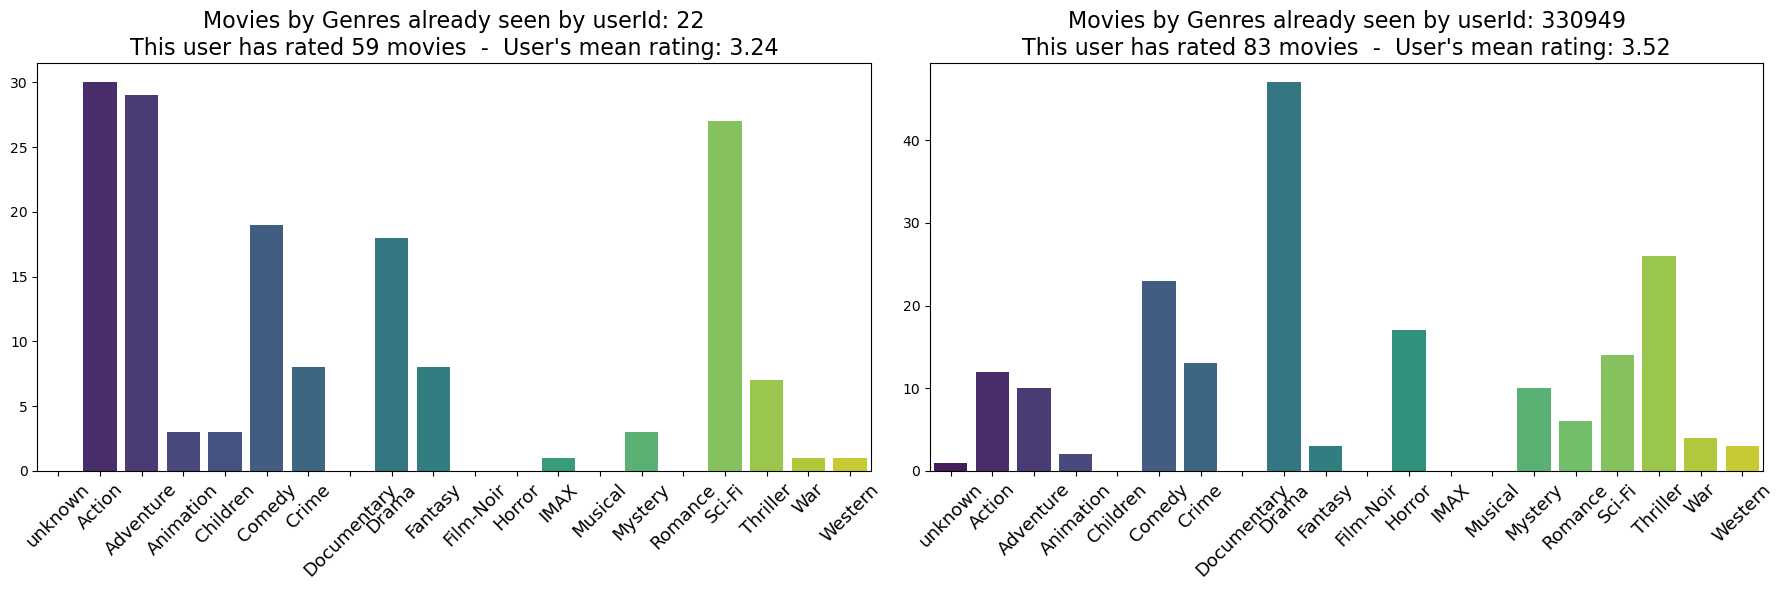

In [25]:
plot_2_users_profile([all_users[0], all_users[-1]], profile_df)

### Popular Movies
We want to know what movies are popular in MovieLens dataset. How do we define popular? I will use IMDB formula for movie score, which they're using for calculating the top rated 250 movies.

$$Weighted Rating \; (WR) = \frac{v}{(v + m)} * R + \frac{m}{(v + m)} * C$$

* R : average rating for the movie
* v : number of votes for the movie
* m : minimum votes (minimum rating count), we will set this to 100 for our data
* C : the mean vote across the whole data

In [128]:
ratings_popular = pd.DataFrame(ratings.groupby(['movieId'], as_index=False)['rating'].mean())
ratings_popular = ratings_popular.rename(columns={'rating': 'mean_rating'})
ratings_popular['count_rating'] = ratings_viz['count_rating'].values

In [129]:
ratings_popular = ratings_popular[ratings_popular.count_rating > 100]

In [131]:
def calc_mv_score(row):
    C = ratings_popular.mean_rating.mean()
    m = 100
    R = row['mean_rating']
    v = row['count_rating']
    score = (v/(v + m)) * R + (m / (v + m)) * C
    return score

In [132]:
ratings_popular['WR'] = ratings_popular.apply(calc_mv_score, axis=1)

In [133]:
ratings_popular = ratings_popular.merge(movies, on='movieId')

top25_popular_mv = ratings_popular.sort_values(by='WR', ascending=False)[:25]

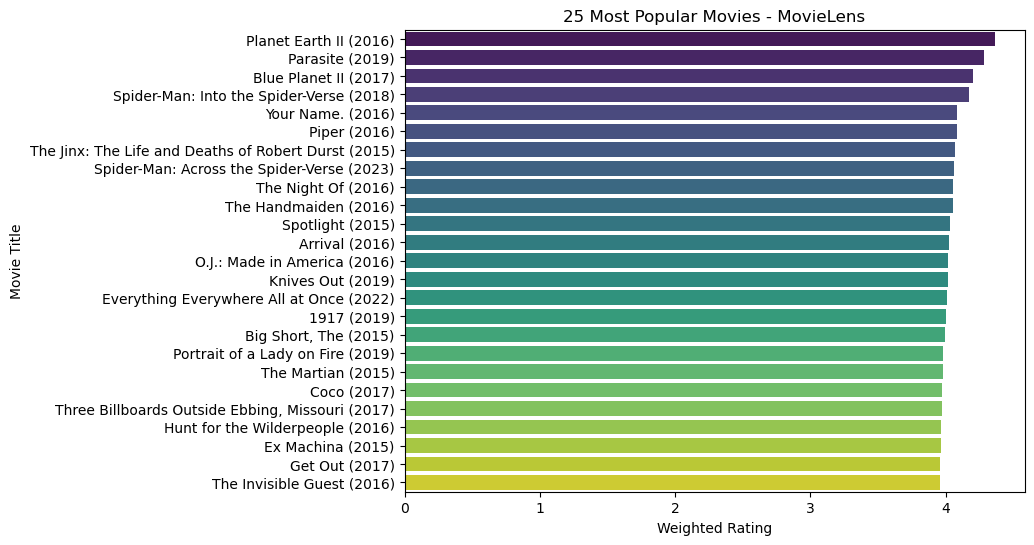

In [134]:
# Create a horizontal bar plot using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='WR', y='title', data=top25_popular_mv, palette='viridis')
plt.xlabel('Weighted Rating')
plt.ylabel('Movie Title')
plt.title('25 Most Popular Movies - MovieLens');

## 3. Content Based Recommender System
Here, we will use the most relevant tags for each movie in movie_tags data that we saved in the cleaning process, to make movies recommendations based on user history or an input (target) movie. By analyzing these tags and comparing them to a target movie or the past user's preferences, the system can recommend movies that share similar characteristics.

In [52]:
pd.set_option('display.max_colwidth', None)
movies_tags.head(3)

,movieId,title,tag
0,1,Toy Story,"3d,action,adventure,affectionate,animal movie,animals,animated,animation,buddy movie,bullying,cartoon,catastrophe,cgi,chase,childhood,children,classic,clever,colourful,comedy,computer animation,cool,creativity,cult classic,cute,cute!,dialogue,disney,disney animated feature,emotional,entertaining,excellent,excellent script,exciting,family,fantasy,feel good movie,feel-good,friendship,fun,fun movie,funny,good,good action,good sequel,good soundtrack,great,great ending,great movie,greed,happy ending,heartwarming,highly quotable,honest,humorous,idealism,imagination,imdb top 250,interesting,kids,kids and family,life philosophy,light,masterpiece,mentor,movielens top pick,nostalgic,original,original plot,oscar,oscar (best animated feature),oscar (best directing),oscar (best effects - visual effects),oscar (best writing - screenplay written directly for the screen),oscar winner,pg,pixar,pixar animation,plot,quotable,redemption,runaway,saturn award (best special effects),sentimental,simple,story,storytelling,suprisingly clever,sweet,talky,technology,touching,toys,unlikely friendships,very funny,very good,visual,visually stunning,whimsical,witty"
1,2,Jumanji,"action,action packed,adaptation,adapted from:book,adventure,animals,bad cgi,based on a book,based on a video game,based on book,big budget,books,bullying,catastrophe,cgi,chase,childhood,children,clever,comedy,coming of age,computer animation,computer game,courage,creativity,cult classic,culture clash,cute,destiny,dinosaurs,dynamic cgi action,effects,entertaining,exciting,family,fantasy,fantasy world,feel good movie,feel-good,first contact,franchise,friendship,fun,fun movie,good,good action,good versus evil,great,great ending,great movie,greed,happy ending,heartwarming,high fantasy,imagination,interesting,jungle,kids,kids and family,life philosophy,light,lions,magic,mentor,monkey,monster,mythology,natural disaster,nostalgic,original,original plot,parallel universe,pg,pg-13,predictable,redemption,runaway,saturn award (best special effects),scary,scifi,secrets,sentimental,silly fun,small town,so bad it's funny,special effects,spiders,story,storytelling,supernatural,survival,suspense,technology,time travel,transformation,video game,video games,videogame,visual,weird"
2,3,Grumpier Old Men,"adventure,aging,bad plot,brutality,california,catastrophe,chase,comedy,corruption,crappy sequel,criterion,crude humor,culture clash,death,destiny,dialogue,dreamlike,drinking,entertaining,entirely dialogue,family,fantasy world,feel good movie,feel-good,fight scenes,fish,foul language,franchise,friendship,fun,fun movie,funny,girlie movie,good,good sequel,good soundtrack,great,great acting,great ending,great movie,greed,gunfight,happy ending,hilarious,indians,insanity,justice,lame,life & death,life philosophy,lone hero,marriage,melancholic,mentor,minnesota,multiple storylines,natural disaster,not as good as the first,nudity (full frontal - brief),original,overrated,pg-13,plot,predictable,prequel,redemption,relationships,revenge,romance,romantic comedy,runaway,script,sentimental,sequel,sequels,sexy,shopping,silly,silly fun,slapstick,small town,so bad it's funny,stereotypes,story,storytelling,suspense,sweet,touching,transformation,twist ending,twists & turns,unfunny,unlikely friendships,unusual plot structure,vengeance,very funny,wedding,weird,witty,women"


In [61]:
pd.reset_option('display.max_colwidth')
print('The movies_tags data contains 100 most relevance tags for each movie. It has {} unique movies.'.\
      format(movies_tags.movieId.nunique()))

The movies_tags data contains 100 most relevance tags for each movie. It has 16376 unique movies.


### Doc2Vec document
We will create a corpus of movies tags from the most relevant tags in our movies_tags data, tokenize (also remove stopwords and punctuations in the process), and preprocess this document before feeding it into a Doc2Vec model from Gensim. 

We then can utilize the most_similar method from Doc2Vec to obtain the most similar movies to a target movie. 

The most_similar method in Gensim's Doc2Vec model uses the cosine similarity metric to measure the similarity between document vectors. It is a common choice for measuring similarity between vectors in high-dimensional spaces, such as the embedding space generated by Doc2Vec.

In [26]:
# compile a collection of movie tags
mv_tags_docs = movies_tags.tag.values

In [28]:
stop_words = stopwords.words('english')

def preprocess(doc):
    # Tokenize the text into words
    tokens = word_tokenize(doc.lower())
    
    # remove stopwords and retain only alphabet and number (thus will remove punctuations)
    filtered_tokens = [word for word in tokens if word.isalnum() and not word in stop_words]
    
    # remove duplicates
    unique_tokens = list(set(filtered_tokens))
    
    return unique_tokens

In [21]:
t0 = time.time()

# create a TaggedDocument objects
print('Creating a TaggedDocument objects ..')
mv_tags_processed = [TaggedDocument(words=preprocess(doc), tags=[str(idx)]) for idx, doc in enumerate(mv_tags_docs)]

# Train a Doc2Vec model
model = Doc2Vec(epochs=50, vector_size=20, alpha=0.025, min_alpha=0.00025, min_count=1, dm=0, workers=4)
model.build_vocab(mv_tags_processed)

def _progress(count):
    sys.stdout.write('\rProgress status : %d %%' % (float(count/50)*100))
    sys.stdout.flush()

n_epochs = 50
print('Training a Doc2Vec model ..')
for epoch in range(n_epochs):
    random.shuffle(mv_tags_processed)
    
    model.train(mv_tags_processed, total_examples=model.corpus_count, epochs=model.epochs)
    
    # decrease the learning rate
    model.alpha -= 0.00025
    
    # set min_alpha to be the same as alpha at each step to prevent further decay.
    model.min_alpha = model.alpha
    
    _progress(epoch+1)

elapsed_time = time.time() - t0
print('\nCreating and training Doc2Vec model in {} minutes'.format(round(elapsed_time/60, 2)))

Creating a TaggedDocument objects ..
Training a Doc2Vec model ..
Progress status : 100 %
Creating and training Doc2Vec model in 47.21 minutes


In [109]:
# Save the trained model to a file
model.save('recsys/doc2vec_model.model')

### Skip training Doc2Vec model

In [29]:
# Load the saved model
model = Doc2Vec.load('recsys/doc2vec_model.model')

mv_tags_docs = movies_tags.tag.values
mv_tags_processed = [TaggedDocument(words=preprocess(doc), tags=[str(idx)]) for idx, doc in enumerate(mv_tags_docs)]

In [30]:
# use most_similar method from gensim model to get most similar movies to a target movie
target_mv = 'A Beautiful Mind'

mv_index = movies_tags[movies_tags['title'] == target_mv].index.values[0]

sims = model.dv.most_similar(positive = [mv_index], topn = 30)

print('Movies Recommendation that are similar to "{}":\n'.format(target_mv))
for i, _ in sims:
    print(movies_tags.loc[int(i), 'title'])

Movies Recommendation that are similar to "A Beautiful Mind":

Rain Man
Good Will Hunting
The Shawshank Redemption
One Flew Over the Cuckoo's Nest
Citizen Kane
The Missing
Iris
Stranger than Fiction
Awakenings
The Aviator
Whitney
Love & Mercy
Get Low
It's a Wonderful Life
Groundhog Day
The Straight Story
Truly, Madly, Deeply
Along with the Gods: The Two Worlds
Lars and the Real Girl
Dead Poets Society
Shine
Random Harvest
The Sixth Sense
Moss
Stand by Me
Mumford
The Machinist
Into the Wild
What's Eating Gilbert Grape
Venus


### Movies Vectors Projection to 2D and 3D - UMAP
We will get the document vector from our Doc2Vec model. This object contains the paragraph vectors learned from the training data. There will be one such vector for each unique document tag supplied during training, and they may be individually accessed using the tag as an indexed-access key.

Then project the high dimensional movie vectors to 2D and 3D with UMAP. Some movies are annotated on the plot.

**Note**: UMAP is a stochastic algorithm – it makes use of randomness both to speed up approximation steps, and to aid in solving hard optimization problems. This means that different runs of UMAP can produce different results.

In [31]:
doc_vectors = np.array([model[doc_id] for doc_id in range(len(mv_tags_processed))])

In [32]:
umap_model = UMAP(n_neighbors=5, min_dist=0.01, metric='cosine', n_components=2)
embedding = umap_model.fit_transform(doc_vectors)

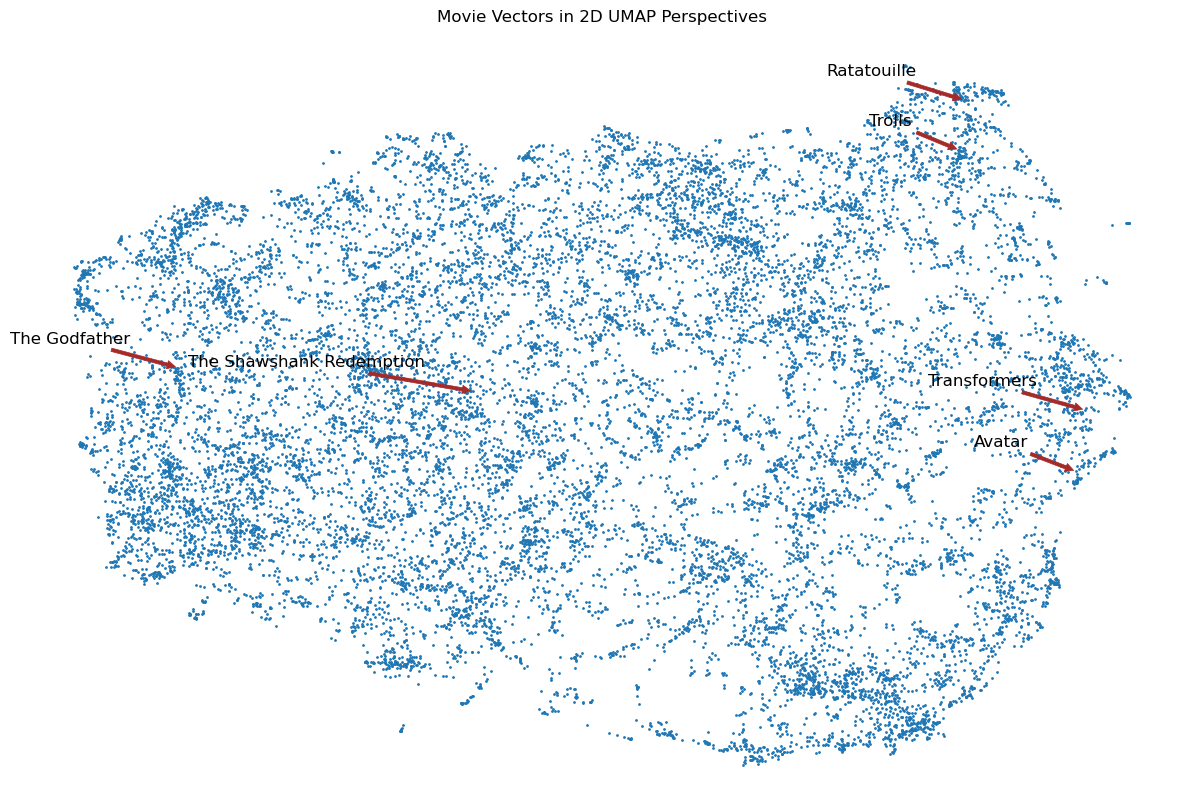

In [34]:
plt.figure(figsize=(15, 10))

x, y = embedding[:, 0], embedding[:, 1]
plt.scatter(x, y, s = 1)
plt.title('Movie Vectors in 2D UMAP Perspectives')
plt.axis('off')

movies_list = ['The Godfather', 'Trolls', 'Avatar', 'The Shawshank Redemption', 'Transformers', 'Ratatouille']
for mv in movies_list:
    idx = movies_tags[movies_tags.title == mv].index.values[0]
    plt.annotate(mv,
                xy = (embedding[idx, 0], embedding[idx, 1]),
                xytext = (embedding[idx, 0] - 0.5, embedding[idx, 1] + 0.5),
                xycoords = 'data',
                fontsize=12,
                arrowprops = dict(arrowstyle='simple', color='brown', linewidth=0.5),
                horizontalalignment='right', verticalalignment='top')

The 2D projection from UMAP placed both Ratatouille and Trolls in close proximity. Both movies have similar tags such as: animation, children, computer animation, comedy, etc. They are closed to each other in the feature space.

In [19]:
# plot the UMAP embedding in 3D using plotly
import plotly.graph_objs as go

umap_model = UMAP(n_neighbors=5, min_dist=0.01, metric='cosine', n_components=3)
embedding = umap_model.fit_transform(doc_vectors)

# create a list of tuples: (movies index, title), that will be annotated on the plot
idx_title = []
for mv in movies_list:
    idx_title.append((movies_tags[movies_tags.title == mv].index.values[0], mv))

fig = go.Figure()
annotations = [dict(
            x=embedding[i, 0],
            y=embedding[i, 1],
            z=embedding[i, 2],
            text=title,
            showarrow=True,
            arrowhead=7,
            xanchor='left',
            yanchor='bottom',
            xshift=5,
            ax=0,
            ay=-40)
    for i, title in idx_title]

# create a scatter3d trace with annotations
scatter3d_trace = go.Scatter3d(x=embedding[:, 0],
                               y=embedding[:, 1],
                               z=embedding[:, 2],
                               mode='markers+text',
                               marker=dict(size=1, color=np.arange(len(embedding)), colorscale='Viridis', opacity=0.5))

fig.add_trace(scatter3d_trace)
fig.update_layout(scene=dict(
                  aspectmode='data',
                  annotations=annotations))
fig.update_layout(title_text='Movie Vectors in 3D UMAP Perspectives')

In [77]:
fig.write_html('movie_vectors_umap_3D.html')

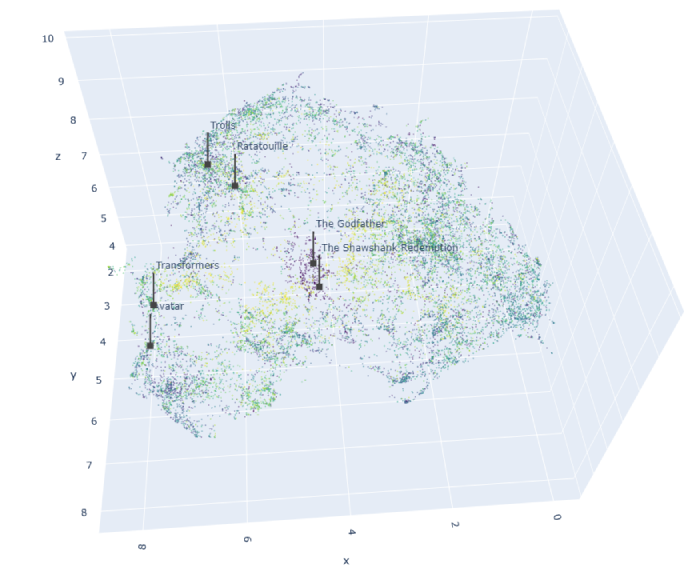

### Make Recommendation based on User History

In [35]:
# supposed these are the movies a certain user has watched and liked:
user_movies = ['The Shawshank Redemption', 'Good Will Hunting', 'The Matrix', 
               'Interstellar', 'Rain Man', 'Inception']

# compute user vector as an average of movie vectors seen by this user
user_movie_vector = np.zeros(shape = doc_vectors.shape[1])

for mv in user_movies:
    mv_index = movies_tags[movies_tags['title'] == mv].index.values[0]  
    user_movie_vector += doc_vectors[mv_index]

user_movie_vector /= len(user_movies)  
  
# use the model's most_similar method to generate movie recommendation
print('Movie Recommendation:\n')
sims = model.dv.most_similar(positive = [user_movie_vector], topn = 30)
for i, j in sims:
    movie_sim = movies_tags.loc[int(i), 'title']
    if movie_sim not in user_movies:
        print(movie_sim)

Movie Recommendation:

Predestination
Amadeus
The Aviator
Minority Report
Supermensch: The Legend of Shep Gordon
The Curious Case of Benjamin Button
The Truman Show
La La Land
Cosmos
The Man from Earth
A Beautiful Mind
Seven Pounds
Star Trek
Mr. Nobody
Gattaca
Whiplash
Star Trek II: The Wrath of Khan
Terminator 2: Judgment Day
Arrival
The Martian
The Soloist
Without Limits
It's a Wonderful Life
21 Grams
Cast Away


### Conclusion
Content-based recommender systems provides personalized recommendations based on users' preferences and movies characteristics. However, like any system, they also have drawbacks.
* The model can only make recommendations based on existing preferences of the users, i.e. the model has limited ability to expand on the users' existing preferences.
* No Collaborative Filtering: Content-based systems don't consider collaborative filtering, which leverages the preferences and behaviors of similar users. This can result in missing out on potential recommendations that could be derived from the wisdom of the crowd.

## 4. Item-based Collaborative Filtering
A simplified example on how predict rating for a particular movie (movie 1) not yet rated by an active user (user 5):

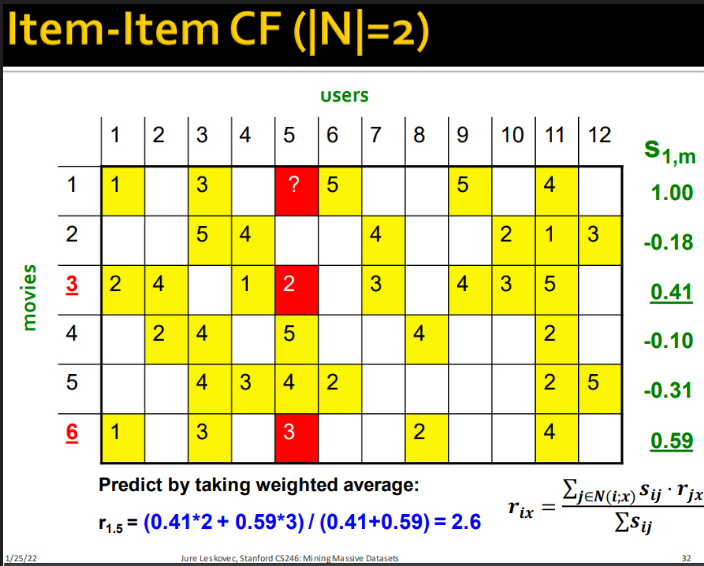

Rating prediction for item-based Collaborative Filtering is given by the following formula :

\begin{equation}
 \hat{r}_{u,i}=\frac{\sum_{i\in S^{(i)}}r_{u,j}\cdot w_{i,j}}{\sum_{j\in S^{(i)}}|w_{i,j}|}
\end{equation}

where:
* $\hat{r}_{u, i}$ is the estimated rating by user $u$ on an unseen item $i$
* $r_{u, j}$ is the rating by user $u$ on item $j$
* $w_{i, j}$ is the similarity (weight) between unseen item $i$ and item $j$
* $S^{(i)}$ is the set of items rated by user $u$ that are similar to unseen item $i$

To compute similarity between item $i$ and item $j$, we need to:
1. Mean-centered ratings, which is done by subtracting the average rating given by user to all items from each item rated by that user. This brings all users to the same level by removing their biases. 
2. Find all users who have rated both $i$ and $j$
3. Apply cosine metric to the normalized ratings to get similarity between $i$ and $j$

We will use Sklearn's LabelEncoder to encode userId and movieId instead of implementing them ourselves like we did in in the Content Based Recommender: RecSys.

A simplified example on how to find candidate movies for user 7 (U7), with the parameter: number of neighbors = 2. We find the 2 most similar neighbors to M2 and M3 but not M9 (since it was rated unfavorably by User 7) and we have candidate movies: M1, M4, M5 and M6. We then make rating prediction for each movie in candidate movies, sort candidate movies by rating predictions and finally recommend the top n movies.

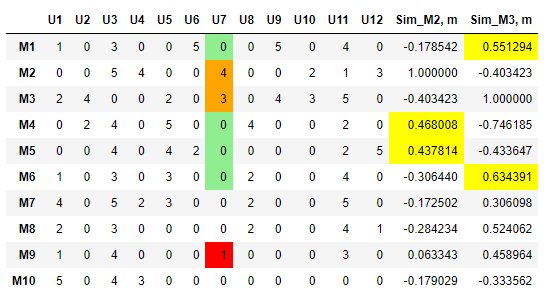

In [36]:
def ids_encoder(ratings):
    """
    Create label encoder for userId and movieId
    Encode ratings.userId and ratings.movieId
    """
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['movieId'].unique())

    # create users encoder (uencoder) and movies/items encoder
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and movies ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    # encode userids and itemids
    ratings.userId = uencoder.transform(ratings.userId.tolist())
    ratings.movieId = iencoder.transform(ratings.movieId.tolist())

    return uencoder, iencoder, ratings

In [6]:
ratings, movies, _ = load_data()

uencoder, iencoder, ratings = ids_encoder(ratings)

In [37]:
def mean_centered(ratings):
    """
    :return: 1. numpy representation of mean rating for each user
             2. norm_ratings dataframe with mean rating and mean-centered rating columns
    """
    # compute mean rating for each user
    users_mean = ratings.groupby('userId', as_index=False)['rating'].mean()
    
    # merge users_mean and ratings on 'userid'
    norm_ratings = pd.merge(ratings, users_mean, suffixes=('', '_mean'), on='userId')
    
    # mean-centered each rating by substracting the mean rating of each corresponding user
    norm_ratings['norm_rating'] = norm_ratings['rating'] - norm_ratings['rating_mean']
    
    # return both the mean rating for each user (return only the mean rating column),
    # and the mean-centered ratings 
    return users_mean.to_numpy()[:, 1], norm_ratings

In [8]:
users_mean, norm_ratings = mean_centered(ratings)

# split norm_ratings into train and test set, we need the normalized rating column
# to construct the rating matrix
train, test = train_test_split(norm_ratings, test_size=0.1, stratify=ratings.rating, random_state=42)

# create numpy representation of norm_ratings
np_ratings = norm_ratings.to_numpy()

In [12]:
norm_ratings

,userId,movieId,rating,rating_mean,norm_rating
0,0,0,1.5,3.237288,-1.737288
1,0,4,3.0,3.237288,-0.237288
2,0,7,2.0,3.237288,-1.237288
3,0,13,4.5,3.237288,1.262712
4,0,15,4.5,3.237288,1.262712
...,...,...,...,...,...
1692156,21980,12004,4.0,3.524096,0.475904
1692157,21980,12649,3.0,3.524096,-0.524096
1692158,21980,13843,4.0,3.524096,0.475904
1692159,21980,13901,3.5,3.524096,-0.024096


In [38]:
def get_movie_user_matrix(norm_ratings, train):
    """
    Create a Rating Matrix, where rating data comes from the train set 
    of shape (#alluser, #allmovies)
    :return: A sparse rating matrix of COOrdinate format
    """
    allusers = list(norm_ratings.userId.unique())
    allmovies = list(norm_ratings.movieId.unique())
    ind_movie = train.movieId
    ind_user = train.userId
    rating_train = list(train.norm_rating)
        
    return coo_matrix((rating_train, (ind_movie, ind_user)), shape=(len(allmovies), len(allusers)))

In [10]:
R = get_movie_user_matrix(norm_ratings, train)

### Nearest Neighbors estimator
Sklearn library has **NearestNeighbors** class, which according to its documentation is an "Unsupervised learner for implementing neighbor searches."

We will use NearestNeighbors to simplifies the computation of neighbors. The metric that will be used to compute similarities is cosine. Why cosine metric?

Different users may have diverse rating tendencies. Some users might be generally more generous in giving high ratings, while others might be more conservative and tend to give lower ratings. Cosine similarity is not sensitive to the magnitude of vectors. It focuses on the direction or orientation of vectors, making it less influenced by overall rating scales that users may use differently.

Explanation:

* The kneighbors method in unsupervised nearest neighbors takes a query point or set of query points (X) and finds the specified number of nearest neighbors in the training data.
* It returns the distances and indices of these neighbors.
* The distances array contains the distances from each query point to its k-nearest neighbors.
* The indices array contains the indices of the k-nearest neighbors in the training data.

**Example usage**:

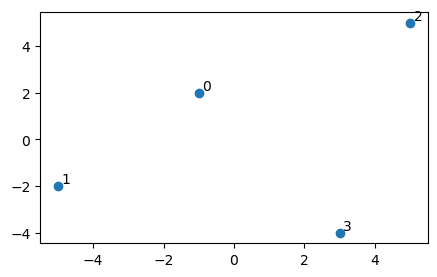

In [27]:
X = np.array([[-1, 2], [-5, -2], [5, 5], [3, -4]])

# plot data, annotate each point with its index
names = ['0', '1', '2', '3']
plt.figure(figsize=(5, 3))
plt.scatter(X[:, 0], X[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (X[i, 0]+0.1, X[i, 1]+0.1))

In [28]:
model_NN = NearestNeighbors(n_neighbors=4, metric='cosine').fit(X)
cosine_distances, neighbor_indices = model_NN.kneighbors(X)
cosine_distances   # smaller cosine distances indicates greater similarity

array([[0.        , 0.68377223, 0.91695452, 1.98386991],
       [0.        , 0.91695452, 1.25997347, 1.91914503],
       [0.        , 0.68377223, 1.14142136, 1.91914503],
       [0.        , 1.14142136, 1.25997347, 1.98386991]])

In [29]:
neighbor_indices

array([[0, 2, 1, 3],
       [1, 0, 3, 2],
       [2, 0, 3, 1],
       [3, 2, 1, 0]], dtype=int64)

We will discard the 1st column of cosine_distances, since it's the distance with itself.
The 1st column of neighbor indices will also get discarded, since it is the index of itself.

Smaller cosine distances indicates greater similarity, while larger distances imply greater dissimilarity. The cosine distances range from 0 to 2. To get the similarity measure, we just subtract cosine distance from 1, $sim(a, b) = 1 - distance(a, b)$, hence the cosine similarity range from -1 to 1.

In **lecture video week 3**, the formula for similarity is $sim(a, b) = \frac{1}{1 + (distance(a, b))}$. Here, the similarity will range between 0 and 1. They are equivalent. It's a monotonic transformation, meaning that as the distance increases, the similarity decreases, and vice versa.

### How many neighbors to select?
As experimented by <a href="https://dl.acm.org/doi/10.1145/3130348.3130372">(Herlocker et al. 1999)</a>, $k \in [20, 50]$ is a reasonable starting point in many domains. We will start with k=20.

In [11]:
def get_similarities_neighbors(R, k=20, metric='cosine'):
    """
    :param: R: csr format of the rating_matrix of size (#users, #movies)
    """
    nn_estimator = NearestNeighbors(n_neighbors=k+1, metric=metric, algorithm='brute')
    
    # Fit the nearest neighbors estimator with the csr rating matrix R
    nn_estimator.fit(R)
    
    # get cosine distances, and neighbors indices from kneighbors method
    cosine_distances, neighbors = nn_estimator.kneighbors(R)
    
    # get cosine similarities
    similarities = 1 - cosine_distances
    
    # drop the first column since it's of itself, at distance of zero   
    return similarities[:, 1:], neighbors[:, 1:]

In [12]:
K = 20
similarities, neighbors = get_similarities_neighbors(R, k=K, metric='cosine')

In [13]:
print('Similarity matrix of all movies and their nearest 20 neighbors of shape {}'.format(similarities.shape))
pd.set_option('display.float_format', '{:.3f}'.format)
pd.DataFrame(similarities[:5])

Similarity matrix of all movies and their nearest 20 neighbors of shape (22487, 20)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.312,0.140,0.121,0.121,0.105,0.103,0.103,0.097,0.091,0.089,0.089,0.088,0.088,0.084,0.084,0.084,0.082,0.081,0.081,0.080
1,0.199,0.161,0.143,0.142,0.137,0.133,0.123,0.118,0.117,0.117,0.116,0.116,0.115,0.115,0.114,0.114,0.112,0.112,0.112,0.110
2,0.289,0.225,0.213,0.203,0.191,0.189,0.188,0.177,0.175,0.159,0.158,0.158,0.157,0.153,0.146,0.136,0.133,0.133,0.132,0.126
3,0.160,0.160,0.158,0.156,0.149,0.141,0.136,0.134,0.133,0.130,0.122,0.119,0.118,0.118,0.118,0.118,0.118,0.118,0.116,0.116
4,0.169,0.144,0.142,0.140,0.137,0.126,0.120,0.119,0.100,0.096,0.096,0.095,0.093,0.089,0.087,0.087,0.084,0.080,0.078,0.077


In [14]:
print('Their corresponding neighbors indices:')
pd.DataFrame(neighbors[:5])

Their corresponding neighbors indices:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,6494,321,31,3022,261,331,7,1854,2121,727,14177,905,27,22350,18,19531,400,28,156,551
1,22,150,318,11,320,295,3958,20,9020,1501,378,38,3825,296,5828,182,1241,4052,2865,3516
2,2340,4226,9349,261,452,1001,13,486,3023,1988,93,1247,644,438,3024,1622,10635,10338,4463,7731
3,8402,13952,8556,14599,9809,9707,3470,11608,8766,6370,6369,115,2057,20399,21304,22189,18400,20944,14146,19504
4,6101,33,11,318,18,378,293,21,331,3025,321,10525,20,7082,721,297,720,6199,4730,1702


### Find Similar Movies for Recommendation

Steps to find movies to recommend for an active user:
1. Find all movies that are seen by an active user, that received **'good' ratings**. With the mean-centered ratings, we can just pick those movies that have **positive mean-centered ratings**. (We are not interested in knowing what you don't like but what you like)
2. Find neighbors of each of the 'good' rated movies.
3. Sort by their similarites

In [139]:
def get_candidate_movies(userid):
    """
    :param userid : user id for which we wish to find candidate movies to recommend
    np_ratings : numpy representation of norm_ratings dataframe
    neighbors : neighbors output from NearestNeighbors
    """    
    # Find the set of movies already rated by userid, store in movies_u_rated
    movies_u_rated = np_ratings[np_ratings[:, 0] == userid]    # column 0 of np_ratings is userId column
    
    # include only movies that received 'good' ratings by active user. Since we use mean-centered ratings,
    # that means to include only those movies with positive mean-centered ratings
    movies_u_rated = movies_u_rated[movies_u_rated[:, 4] > 0]
    
    # get only the movieId column
    movies_u_rated = movies_u_rated[:, 1].astype('int')
    
    # Find similar movies/neighbors to each movie in movies_u_rated
    C = set()        
    for mid in movies_u_rated:    
        # add neighbors of each movie that this userid rated, to the set C
        C.update(neighbors[mid])
    
    # exclude from the set C all movies that this userid has rated
    candidates = np.setdiff1d(list(C), movies_u_rated, assume_unique=True)
    
    return movies_u_rated, candidates

In [140]:
test_userId = all_users[0]      # try all_users[-1]
test_userId_encoded = uencoder.transform([test_userId])[0]
movies_u_rated, candidate_movies = get_candidate_movies(test_userId_encoded)

print('The number of movies with positive mean-centered rating already seen by userId {} is: {} movies'.\
      format(test_userId, len(movies_u_rated)))
print('The number of candidate movies to recommend to this user is: {} movies'.format(len(candidate_movies)))

The number of movies with positive mean-centered rating already seen by userId 22 is: 34 movies
The number of candidate movies to recommend to this user is: 237 movies


We need to rank these candidate movies based on their similarities to movies that a certain user has rated, so that we can later picked the top n movies for recommendation. We will implement that in the ItemBasedCF Class below.

### Rating Prediction
Recall the formula for item-based Collaborative Filtering rating prediction :

\begin{equation}
 \hat{r}_{u,i}=\frac{\sum_{i\in S^{(i)}}r_{u,j}\cdot w_{i,j}}{\sum_{j\in S^{(i)}}|w_{i,j}|}
\end{equation}

In [144]:
def predict(userId, movieId):
    """
    :return: rating prediction for a given userId on a given movieId            
    """        
    # get all the ratings by this userId, column 0 of np_ratings is userId column
    user_ratings = np_ratings[np_ratings[:, 0].astype(int) == userId]
    
    # similar movies to movieId that are rated by this user
    Sims_rated_by_u = user_ratings[np.isin(user_ratings[:, 1], neighbors[movieId])]
    
    # get only the rating column
    rating = Sims_rated_by_u[:, 2]
    
    # for each similar movie to movieId that are rated by this userId, get the neighbors indices
    indexes = [np.where(neighbors[movieId] == mid)[0][0] for mid in Sims_rated_by_u[:, 1].astype('int')]
    
    # get their similarities
    sims = similarities[movieId, indexes]
    
    numerator = np.dot(rating, sims)
    denominator = np.sum(np.abs(sims))

    if numerator == 0 or denominator == 0:
        # return users' mean if there is no value 
        # (i.e. if no similar movies to movieId that are rated by this active user)
        return users_mean[userId]
    
    r_hat = numerator / denominator
    return r_hat

### Building an Item-based Collaborative Filtering Class

In [39]:
class ItemBasedCF():
    def __init__(self, ratings, movies, uencoder, iencoder, n_neighbors=20, metric='cosine'):
        self.movies = movies
        self.uencoder = uencoder
        self.iencoder = iencoder
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.users_mean, self.ratings = self.mean_centered(ratings)
        self.np_ratings = self.ratings.to_numpy()
        self.train, self.test = self.train_test_split()
        self.R = self.get_movie_user_matrix()
        self.similarities, self.neighbors = self.get_similarities_neighbors()
        print('Item Based Collaborative Filtering created!')
              
    def mean_centered(self, ratings):
        print('Mean-centering ratings ...')
        users_mean = ratings.groupby('userId', as_index=False)['rating'].mean()
        norm_ratings = pd.merge(ratings, users_mean, suffixes=('', '_mean'), on='userId')
        norm_ratings['norm_rating'] = norm_ratings['rating'] - norm_ratings['rating_mean']
        return users_mean.to_numpy()[:, 1], norm_ratings
       
    def train_test_split(self):
        train, test = train_test_split(self.ratings, test_size=0.1, stratify=ratings.rating, random_state=42)
        return train, test
    
    def get_movie_user_matrix(self):
        """
        Create a Rating Matrix, where rating data comes from the train set of shape (#alluser, #allmovies)
        """
        print('Creating a rating matrix ...')
        allusers = list(self.ratings.userId.unique())
        allmovies = list(self.ratings.movieId.unique())
        ind_movie = self.train.movieId
        ind_user = self.train.userId
        rating_train = list(self.train.norm_rating)      
        return coo_matrix((rating_train, (ind_movie, ind_user)), shape=(len(allmovies), len(allusers)))
    
    def get_similarities_neighbors(self):
        print('Computing k NearestNeighbors ...')
        nn_estimator = NearestNeighbors(n_neighbors=self.n_neighbors+1, metric=self.metric, algorithm='brute')
        nn_estimator.fit(self.R)
        cosine_distances, neighbors = nn_estimator.kneighbors(self.R)
        cosine_similarities = 1 - cosine_distances
        return cosine_similarities[:, 1:], neighbors[:, 1:] 

    def get_candidate_movies(self, userid):
        movies_u_rated = self.np_ratings[self.np_ratings[:, 0] == userid]
        movies_u_rated = movies_u_rated[movies_u_rated[:, 4] > 0]
        movies_u_rated = movies_u_rated[:, 1].astype('int')
        C = set()        
        for mid in movies_u_rated:    
            C.update(self.neighbors[mid]) 
        candidates = np.setdiff1d(list(C), movies_u_rated, assume_unique=True)   
        return movies_u_rated, candidates
    
    def similarity_c(self, c, movies_u_rated):
        w = 0    
        for mid in movies_u_rated:
            if c in self.neighbors[mid] :
                w += self.similarities[mid, self.neighbors[mid] == c][0]
        return w
    
    def get_ranked_candidates(self, candidate_movies, movies_u_rated):
        sims = [self.similarity_c(c, movies_u_rated) for c in candidate_movies]
        pairs = list(zip(candidate_movies, sims))    
        sorted_pairs = sorted(pairs, key=lambda x: x[1], reverse=True)
        ranked_candidates, _ = zip(*sorted_pairs)
        return ranked_candidates
    
    def predict(self, userId, movieId):       
        user_ratings = self.np_ratings[self.np_ratings[:, 0].astype(int) == userId]
        Sims_rated_by_u = user_ratings[np.isin(user_ratings[:, 1], self.neighbors[movieId])]
        rating = Sims_rated_by_u[:, 2]
        indexes = [np.where(self.neighbors[movieId] == mid)[0][0] for mid in Sims_rated_by_u[:, 1].astype('int')]
        sims = self.similarities[movieId, indexes]    
        numerator = np.dot(rating, sims)
        denominator = np.sum(np.abs(sims))
        if numerator == 0 or denominator == 0:
            return self.users_mean[userId]    
        r_hat = numerator / denominator
        return r_hat
    
    def recommender(self, userid, n=30):
        movies_u_rated, candidates = self.get_candidate_movies(userid)
        ranked_candidates = self.get_ranked_candidates(candidates, movies_u_rated)[:n]
        predictions = []
        for mid in ranked_candidates:
            r_hat = self.predict(userid, mid)
            mid_ = self.iencoder.inverse_transform([mid])[0]
            predictions.append((mid_, r_hat))    
        predictions = pd.DataFrame(predictions, columns=['movieId', 'rating_prediction'])
        recommend = pd.merge(predictions, movies, on='movieId', how='inner')
        recommend = recommend.sort_values(by=['rating_prediction'], ascending=False)
        return recommend
    
    def _rmse(self, y_pred, y_true):
        return np.sqrt(((y_true - y_pred)**2).mean())

    def predict_test_data(self):
        test_uid_mid = self.test[['userId', 'movieId']].values
        test_labels = np.array(self.test.rating)
        def _progress(count):
            sys.stdout.write('\rComputing predictions... Progress status : %.1f%%' % (float(count/len(self.test))*100.0))
            sys.stdout.flush()  
        predictions = []
        t0 = time.time()
        for idx, (u, i) in enumerate(test_uid_mid):
            predictions.append(self.predict(u, i))
            _progress(idx)
        elapsed_time = round((time.time() - t0)/60, 2)
        print('\nPredict test data of {} users evaluation in {} minutes'.format(len(self.test), elapsed_time))
        rmse = self._rmse(predictions, test_labels)
        return predictions, rmse

In [40]:
ratings, movies, _ = load_data()

uencoder, iencoder, ratings = ids_encoder(ratings)

cf = ItemBasedCF(ratings, movies, uencoder, iencoder, n_neighbors=20)

Mean-centering ratings ...
Creating a rating matrix ...
Computing k NearestNeighbors ...
Item Based Collaborative Filtering created!


In [64]:
test_user = all_users[0]
test_user_encoded = uencoder.transform([test_user])
movies_recommendation_cf = cf.recommender(test_user_encoded[0], n=30)

In [65]:
print('Top 30 Movies Recommendation for userId: {}'.format(test_user))
movies_recommendation_cf.iloc[:30, :5]

Top 30 Movies Recommendation for userId: 22


,movieId,rating_prediction,title,genres,year
13,254726,3.794246,Dune (2021),Action|Adventure|Drama|Sci-Fi,2021
12,161582,3.781498,Hell or High Water (2016),Crime|Drama,2016
14,203375,3.777742,Ford v. Ferrari (2019),Action|Drama,2019
10,139644,3.776985,Sicario (2015),Crime|Drama|Mystery,2015
26,152970,3.767391,Hunt for the Wilderpeople (2016),Adventure|Comedy,2016
1,202439,3.758989,Parasite (2019),Comedy|Drama,2019
20,174055,3.705217,Dunkirk (2017),Action|Drama|Thriller|War,2017
4,208703,3.690811,1917 (2019),Drama|War,2019
5,177593,3.684588,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama,2017
23,270698,3.659969,Everything Everywhere All at Once (2022),Action|Comedy|Sci-Fi,2022


Let's plot this movie recommendation by genres, then compare it to the movies that have already been seen by this active user.

In [82]:
def plot_recommendation(recommend, test_user, model_name, start_col=6):
    genres_count = recommend.iloc[:, start_col:].sum(axis=0)
    plt.figure(figsize=(8, 3))
    sns.barplot(x=genres_count.index, y=genres_count.values, palette='viridis', width=0.7)
    plt.xticks(rotation=45, fontsize=8)
    title = model_name + ' Movies Recommendation by Genres for userId:' + str(test_user)
    plt.title(title, fontsize=14)
    plt.show()
    
def plot_user_profile(userid, profile_df):
    genres_count = profile_df[profile_df.userId == userid].iloc[:, 6:].sum(axis=0)
    user_mean = round(profile_df[profile_df.userId == userid].rating.mean(), 2)
    user_count = profile_df[profile_df.userId == userid].rating.count()
    plt.figure(figsize=(8, 3))
    sns.barplot(x=genres_count.index, y=genres_count.values, palette='viridis')
    plt.xticks(rotation=45, fontsize=8)
    plt.title("Movies by Genres seen by userId: {}\nThis user has rated {} movies  -  User's mean rating: {}"\
              .format(userid, user_count, user_mean), fontsize=14)
    plt.show()

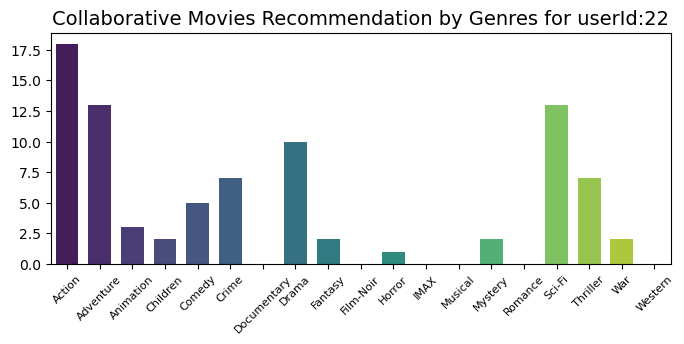

In [83]:
# use movies_recommendation output from cf.recommender()
plot_recommendation(movies_recommendation_cf, test_user, 'Collaborative')

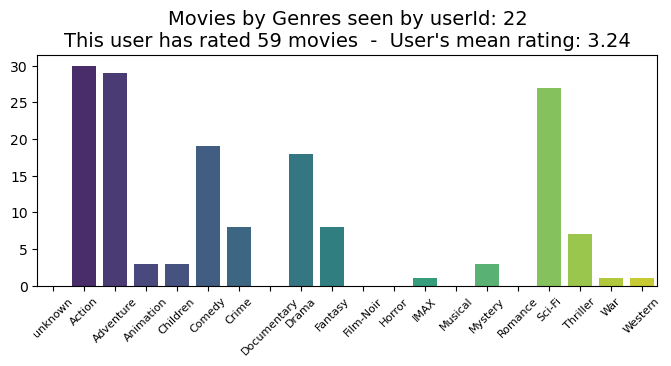

In [67]:
# this function need profile_df that was created earlier in EDA section
plot_user_profile(test_user, profile_df)

The recommender system correctly recommended many Action, Adventure and Sci-Fi movies, in accordant with the user preference. 

### RMSE of the test data

In [145]:
predictions, rmse_cf = cf.predict_test_data()

print('\nRMSE of the test data is {}'.format(round(rmse_cf, 3)))

Computing predictions... Progress status : 100.0%
Predict test data of 169217 users evaluation in 29.56 minutes

RMSE of the test data is 0.836


Changing the parameter n_neighbors in NearestNeighbors to 100 did not lead to a meaningful improvement in RMSE:

In [16]:
cf = ItemBasedCF(ratings, movies, uencoder, iencoder, n_neighbors=100)

predictions, rmse_cf = cf.predict_test_data()
print('\nRMSE of the test data is {}'.format(round(rmse_cf, 3)))

Mean-centering ratings ...
Creating a rating matrix ...
Computing k NearestNeighbors ...
Item Based Collaborative Filtering created!
Computing predictions... Progress status : 100.0%
Predict test data of 169217 users evaluation in 31.54 minutes

RMSE of the test data is 0.825


## 5. Model based Recommender System

### 5.1. Singular Value Decomposition
Singular Value Decomposition (SVD) can be used to predict movie ratings in the context of collaborative filtering. SVD will decompose the user-item matrix into three matrices: U (user matrix), Σ (singular value matrix), and V^T (transpose of the item matrix). We can use the decomposed matrices to reconstruct the original user-item matrix. The missing entries in the reconstructed matrix represent the predicted ratings. We can then recommend movies with high predicted ratings to users.

In [44]:
# To run this cell, we need several functions that were defined in Item-based Collaborative Filtering section.

ratings, movies, _ = load_data()

# Encode userId and movieId
uencoder, iencoder, ratings = ids_encoder(ratings)

# get the mean-centered ratings and users_mean
users_mean, norm_ratings = mean_centered(ratings)

# split norm_ratings into train and test set, we need mean-centered rating column
# to construct the rating matrix
train, test = train_test_split(norm_ratings, test_size=0.1, stratify=ratings.rating, random_state=42)

# create numpy representation of norm_ratings
#np_ratings = norm_ratings.to_numpy()

# get R, the user-movie rating matrix by transposing the movie-user matrix
R_movie_user = get_movie_user_matrix(norm_ratings, train)
R = R_movie_user.toarray().T

In [32]:
t0 = time.time()

U, Sigma, Vt = svd(R)

elapsed_time = (time.time() - t0) / 60
print('SVD evaluation time {} minutes'.format(round(elapsed_time, 2)))

SVD evaluation time 56.65 minutes


Since it took close to an hour to decomposed matrix R using scipy.linalg.svd, we will instead use scipy.sparse.linalg.svds module that is more efficient for large sparse matrices.

### Fit scipy.sparse.linalg.svds model

In [45]:
# we will use 50 as the low rank approximation
rank = 50
U, Sigma, Vt = svds(R, k=rank)

# predict ratings
predicted_ratings = np.dot(np.dot(U, np.diag(Sigma)), Vt)

# add back users mean
predicted_ratings += users_mean[:, np.newaxis]

In [21]:
def predict_all(test, predicted_ratings):
    test_predictions = []
    for i in range(len(test)):
        r_hat = predicted_ratings[test.userId.values[i], test.movieId.values[i]]
        test_predictions.append(r_hat)   
    return np.array(test_predictions)

def calc_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

In [22]:
test_predicted_ratings = predict_all(test, predicted_ratings)

rmse_svds = calc_rmse(test.rating.values, test_predicted_ratings)
print('RMSE of the test data:', rmse_svds)

RMSE of the test data: 0.8387126358690549


### Movie Recommendation

In [71]:
test_user = all_users[0]
test_user_encoded = uencoder.transform([test_user])

In [47]:
def make_recommendation(user, n=30):
    movieIds_seen = ratings[ratings.userId == user].movieId.tolist()
    user_predicted_rating = predicted_ratings[user, :]
    candidate_movies = user_predicted_rating.argsort()[::-1][:n]
    candidate_movies_Id = iencoder.inverse_transform(candidate_movies)
    movies_recommendation = movies[movies.movieId.isin(candidate_movies_Id)]
    return movies_recommendation

In [72]:
movies_recommendation_svd = make_recommendation(test_user_encoded[0], n=30)
movies_recommendation_svd.iloc[:, :3]

,movieId,title,genres
13,122882,Mad Max: Fury Road (2015),Action|Adventure|Sci-Fi|Thriller
15,122886,Star Wars: Episode VII - The Force Awakens (2015),Action|Adventure|Fantasy|Sci-Fi|IMAX
23,122904,Deadpool (2016),Action|Adventure|Comedy|Sci-Fi
27,122912,Avengers: Infinity War - Part I (2018),Action|Adventure|Sci-Fi
28,122914,Avengers: Infinity War - Part II (2019),Action|Adventure|Sci-Fi
29,122916,Thor: Ragnarok (2017),Action|Adventure|Sci-Fi
93,128360,The Hateful Eight (2015),Western
245,133771,The Lobster (2015),Comedy|Romance|Sci-Fi
261,134130,The Martian (2015),Adventure|Drama|Sci-Fi
288,134853,Inside Out (2015),Adventure|Animation|Children|Comedy|Drama|Fantasy


### 5.2 SVD++
We will use Surprise library to create SVD++ model.

In [51]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split as train_test_split_surprise
from surprise.model_selection import GridSearchCV
from surprise import SVDpp
from surprise import accuracy

Surprise is a Python library designed for building and evaluating recommendation systems. 

For their SVD++ algorithm, the rating prediction $\hat{r}_{u,i}$ is set as:

$$\hat{r}_{u,i} = \mu + b_u + b_i + q_i^T \; \left( p_u + |I_u|^{-\frac{1}{2}} \Sigma_{j \in I_u} y_j \right)$$

Where:
* $y_j$: the implicit item factors
* $b_u$: the user bias
* $b_i$: the item bias
* $p_u$: the user factors
* $q_i$: the item factors
* $I_u$: the items that user u rated

Since our data does not include implicit feedback, such as clicks, or likes, here the implicit rating describes the fact that a user rated an item, regardless of the rating value (i.e. even unfavorable ratings can provide valuable information).

Surprise library requires data to be in its own format. We will need to reformat our data and define a Reader object for Surprise to be able to parse our dataframe.

In [52]:
ratings, movies, _ = load_data()
data = ratings[['userId', 'movieId', 'rating']]
data.rename(columns={'userId': 'user_id', 'movieId': 'item_id'}, inplace=True)

min_rating = ratings.rating.min()    # 0.5
max_rating = ratings.rating.max()    # 5.0
reader = Reader(rating_scale=(min_rating, max_rating))
dataset = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], reader=reader)

In [53]:
trainset, testset = train_test_split_surprise(dataset, test_size=0.25)

### Hyperparameter Tuning SVD++

In [71]:
# lr_all: learning rate for all params
# reg_all : regularization term for all params
param_grid = {'n_epochs': [20, 25], 'lr_all': [0.005, 0.007, 0.01], 'reg_all': [0.02, 0.1]}

best_params = {}
best_rmse = float('inf')

t0 = time.time()
for n_epochs in param_grid['n_epochs']:
    for lr_all in param_grid['lr_all']:
        for reg_all in param_grid['reg_all']:
            model = SVDpp(n_epochs=n_epochs, lr_all=lr_all, reg_all=reg_all, random_state=0)

            model.fit(trainset)

            predictions = model.test(testset)

            rmse = accuracy.rmse(predictions)

            # update best parameters if current rmse is lower
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = {'n_epochs': n_epochs, 'lr_all': lr_all, 'reg_all': reg_all}

elapsed_time = (time.time() - t0)/60
print('Hyperparameter tuning in {} minutes'.format(round(elapsed_time, 2)))

print("Best Parameters: ", best_params)
print("Best RMSE: ", best_rmse)

RMSE: 0.7758
RMSE: 0.8062
RMSE: 0.7740
RMSE: 0.7981
RMSE: 0.7787
RMSE: 0.7925
RMSE: 0.7735
RMSE: 0.8004
RMSE: 0.7756
RMSE: 0.7941
RMSE: 0.7837
RMSE: 0.7887
Hyperparameter tuning in 95.65 minutes
Best Parameters:  {'n_epochs': 25, 'lr_all': 0.005, 'reg_all': 0.02}
Best RMSE:  0.7735394826916245


In [54]:
# Fit the model with the best params
t0 = time.time()

model = SVDpp(n_epochs=25, lr_all=0.005, reg_all=0.02, random_state=0)
model.fit(trainset)

elapsed_time = (time.time() - t0)/60
print('Fitting training data to SVD++ model evaluation in {} minutes'.format(round(elapsed_time, 2)))

Fitting training data to SVD++ model evaluation in 6.79 minutes


In [141]:
# predictions on the test data
t0 = time.time()

predictions = model.test(testset)

elapsed_time = (time.time() - t0)/60
print('Prediction of the test data of size {} in {} minutes'.format(len(testset), round(elapsed_time, 2)))
rmse_svd_pp = accuracy.rmse(predictions)

Prediction of the test data of size 423041 in 1.88 minutes
RMSE: 0.7725


In [68]:
# we are using the same test_user that we used earlier to test ItemBasedCF Class.
test_user = all_users[0]

# get items that this active user has not rated
movies_to_recommend = data.loc[~data['item_id'].isin(data[data['user_id'] == test_user]['item_id'].values), 'item_id']

# generate predictions for the user on unrated movies
user_predictions = [model.predict(test_user, item_id) for item_id in movies_to_recommend]

**Prediction** from Surprise library has its own format, as can be seen below:

In [69]:
user_predictions[test_user]

Prediction(uid=22, iid=176751, r_ui=None, est=3.3247046983579587, details={'was_impossible': False})

We will retrieve movieIds and estimated rating information, merge them with the movies dataset, sort by rating predictions since we want to recommend movies that the user might like, and finally, display the recommendations.

In [70]:
preds_dict = {'movieId': [], 'rating_prediction': []}
for pred in user_predictions:
    preds_dict['movieId'].append(pred[1])
    preds_dict['rating_prediction'].append(pred[3])

preds_df = pd.DataFrame(preds_dict)
preds_df = preds_df.drop_duplicates(keep='last')
preds_movie_title = movies[movies.movieId.isin(preds_df.movieId.values)]
movies_recommendation_svdpp = pd.merge(preds_df, preds_movie_title, on='movieId').sort_values(by='rating_prediction', ascending=False)
movies_recommendation_svdpp = movies_recommendation_svdpp[:30]
movies_recommendation_svdpp.iloc[:, :4]

,movieId,rating_prediction,title,genres
21602,171011,4.465425,Planet Earth II (2016),Documentary
19807,197041,4.421112,Double King (2017),Animation
21268,179135,4.412063,Blue Planet II (2017),Documentary
14171,242210,4.373810,James Acaster: Cold Lasagne Hate Myself 1999 (...,Comedy
19817,160289,4.337176,O.J.: Made in America (2016),Documentary
21885,131724,4.315159,The Jinx: The Life and Deaths of Robert Durst ...,Documentary
16470,208116,4.270683,Everything Is Terrible! Presents: The Great Sa...,Comedy|Fantasy|Horror
22362,270698,4.248219,Everything Everywhere All at Once (2022),Action|Comedy|Sci-Fi
19854,152065,4.228347,Embrace of the Serpent (2016),Adventure|Drama
22344,197879,4.221712,Apollo 11 (2019),Documentary


## 6. Conclusion

In [146]:
# RMSE Comparison
pd.DataFrame({'Method': ['Collaborative, NearestNeighbors', 'Scipy svds - rank=50', 'Surprise SVD++'],
              'RMSE': [rmse_cf, rmse_svds, rmse_svd_pp]})

,Method,RMSE
0,"Collaborative, NearestNeighbors",0.836274
1,Scipy svds - rank=50,0.838713
2,Surprise SVD++,0.772525


In terms of RMSE performance, SVD++ from the Surprise Library is the best model by far. It is also the fastest algorithm. That wasn't a surprise, since the algorithm is specifically designed for building and evaluating recommendation systems.

In [73]:
# Movies Recommendation Comparison
df = pd.DataFrame({'Collaborative, 20-NearestNeighbors': movies_recommendation_cf.title.tolist(), 
                   'Scipy svds - rank=50': movies_recommendation_svd.title.tolist(), 
                   'Surprise SVD++': movies_recommendation_svdpp.title.tolist()})
print('Movies Recommendations for userId {} by the different models:'.format(test_user))
df

Movies Recommendations for userId 22 by the different models:


,"Collaborative, 20-NearestNeighbors",Scipy svds - rank=50,Surprise SVD++
0,Dune (2021),Mad Max: Fury Road (2015),Planet Earth II (2016)
1,Hell or High Water (2016),Star Wars: Episode VII - The Force Awakens (2015),Double King (2017)
2,Ford v. Ferrari (2019),Deadpool (2016),Blue Planet II (2017)
3,Sicario (2015),Avengers: Infinity War - Part I (2018),James Acaster: Cold Lasagne Hate Myself 1999 (...
4,Hunt for the Wilderpeople (2016),Avengers: Infinity War - Part II (2019),O.J.: Made in America (2016)
5,Parasite (2019),Thor: Ragnarok (2017),The Jinx: The Life and Deaths of Robert Durst ...
6,Dunkirk (2017),The Hateful Eight (2015),Everything Is Terrible! Presents: The Great Sa...
7,1917 (2019),The Lobster (2015),Everything Everywhere All at Once (2022)
8,"Three Billboards Outside Ebbing, Missouri (2017)",The Martian (2015),Embrace of the Serpent (2016)
9,Everything Everywhere All at Once (2022),Inside Out (2015),Apollo 11 (2019)


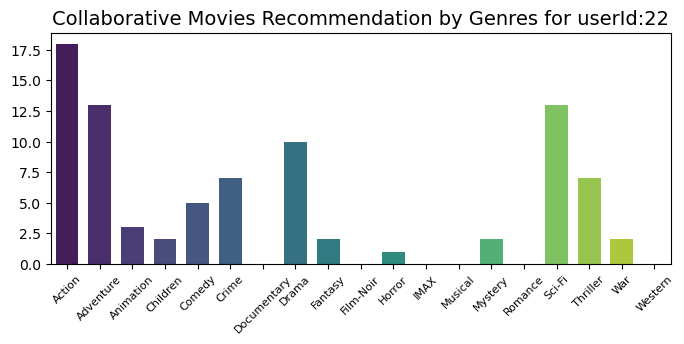

In [84]:
plot_recommendation(movies_recommendation_cf, test_user, 'Collaborative')

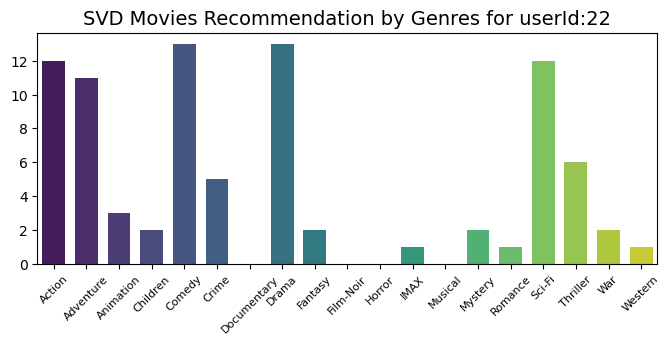

In [85]:
plot_recommendation(movies_recommendation_svd, test_user, 'SVD', start_col=5)

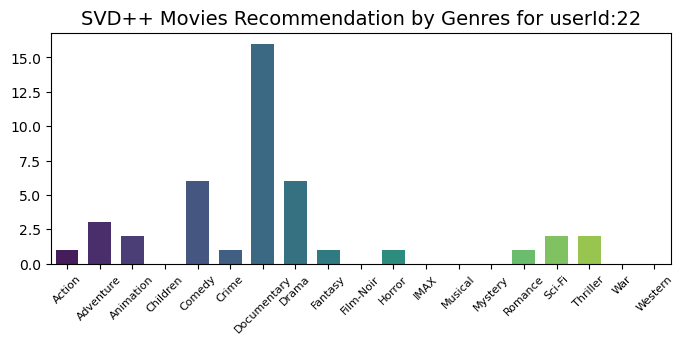

In [86]:
plot_recommendation(movies_recommendation_svdpp, test_user, 'SVD++')

Movies recommended by the different models are quite different. Let's discuss each model and potential reasons for the variations:

* Content-Based by Movie Tags:
   * This model recommends movies based on tags associated with each movie. If two movies share similar tags, they are likely to be recommended together.
<br>

While both item-based collaborative filtering and SVD are collaborative filtering techniques, they are different in their approach to similarity: 
* Item-based model identifies similarity between items (movies) based on user interactions. If two movies have similar user engagement patterns (i.e., users who liked one movie also liked the other), they will be recommended together.
<br>
* SVD decomposes the user-movie rating matrix into latent factors, representing hidden features. We used rank (latent factors) = 50 in SVDs, and the default for n_factors in SVD++ is 100. Recommendations are made based on the latent factors, and movies are considered similar if they share similar latent factor values. Variations in recommendations may come from the way the model captures latent features and the weight assigned to different factors.

### References:
1. Jure Leskovec, Anand Rajaraman, Jeff Ullman: Mining of Massive Datasets:
   * Website: http://www.mmds.org/
2. Steve Brunton: Databook Python Repository:
   * GitHub Repository: https://github.com/dynamicslab/databook_python
3. Steve Brunton: Singular Value Decomposition (SVD): Matrix Approximation
   * YouTube Video: https://www.youtube.com/watch?v=xy3QyyhiuY4
4. Johnson Kuan: Towards Data Science Article on Movie Recommender System:
   * Article: https://towardsdatascience.com/how-to-build-a-simple-movie-recommender-system-with-tags-b9ab5cb3b616
5. Simon Funk and Mark Stevenson and James Bennett and F. Maxwell Harper: Python Library: Surprise:
   * Documentation: https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp
5. Carmel Wenga: GitHub Repository for Item-based Collaborative Filtering:
   * GitHub Repository: https://github.com/nzhinusoftcm/review-on-collaborative-filtering/blob/master/3.Item-basedCollaborativeFiltering.ipynb